## Pratica 1 - Aprendizaje automatico

En este notebook desarrollo la Práctica 1 de Aprendizaje Automático sobre un conjunto de datos bancario, con el objetivo de construir un flujo completo y reproducible desde el análisis inicial hasta la obtención de un modelo final listo para usarse y desplegarse. El trabajo se organiza en fases: 
- (1) EDA, para comprender la estructura del dataset, la calidad de los datos y el comportamiento de la variable objetivo deposit; 
- (2) preprocesamiento mediante pipelines, justificando decisiones como imputación, escalado y codificación; 
- (3) entrenamiento y comparación de modelos (básicos y avanzados) usando validación cruzada interna para seleccionar hiperparámetros; 
- (4) evaluación final con una partición holdout para estimar el rendimiento esperado en datos no vistos. Con el fin de facilitar la corrección, cada decisión queda respaldada por resultados cuantitativos (métricas, tiempos de ejecución y visualizaciones) y se controla la aleatoriedad mediante una semilla fija para garantizar reproducibilidad.

Ha sido realizada por Diego Valladares - 100475849

In [125]:
import numpy as np
import pandas as pd

ava_data = pd.read_pickle ("bank_05.pkl")
comp_data = pd.read_pickle ("bank_competition.pkl")

Empiezo visualizando las primeras filas para hacerme una idea rápida de las variables disponibles, el formato y el tipo de información (numéricas vs categóricas).

In [126]:
ava_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,None,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,None,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Compruebo el tamaño del conjunto de datos. Esto me permite saber cuántas observaciones tengo para entrenar y cuántas variables voy a preprocesar.

In [127]:
ava_data.shape

(11000, 17)

Como ya conocemos las variables predictoras, dejo una tabla con ellas
### Diccionario de variables

| Campo       | Descripción |
|------------|-------------|
| `age`      | Edad del cliente |
| `job`      | Tipo de trabajo |
| `marital`  | Estado civil |
| `education`| Nivel de formación |
| `default`  | ¿Tiene créditos no devueltos? |
| `balance`  | Saldo medio anual (€) |
| `housing`  | ¿Tiene préstamos hipotecarios? |
| `loan`     | ¿Tiene un préstamo personal? |
| `contact`  | Tipo de comunicación de contacto |
| `day`      | Último día de contacto del mes (numérico) |
| `month`    | Último mes de contacto del año |
| `duration` | Duración del último contacto, en segundos |
| `campaign` | Número de contactos realizados durante esta campaña y para este cliente |
| `pdays`    | Número de días transcurridos desde la última vez que se contactó con el cliente en una campaña anterior (numérico, `-1` significa que no se contactó previamente con el cliente) |
| `previous` | Número de contactos realizados antes de esta campaña y para este cliente |
| `poutcome` | Resultado de la campaña de marketing anterior |
| `deposit`  | ¿El cliente ha suscrito un depósito a plazo fijo? (variable objetivo) |

> Nota: `deposit` es la variable objetivo (clasificación binaria). En el conjunto `bank_competition` no aparece esta columna.

----
### Estructura y valores no nulos

A continuación utilizo `info()` para obtener un resumen rápido del dataset: número de filas/columnas, tipo de dato de cada variable y, sobre todo, el recuento de valores **no nulos** por columna, lo que permite detectar de forma inmediata si existen variables con valores perdidos.

In [128]:
ava_data.info()

<class 'pandas.DataFrame'>
Index: 11000 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11000 non-null  int64 
 1   job        11000 non-null  object
 2   marital    10468 non-null  object
 3   education  11000 non-null  object
 4   default    11000 non-null  object
 5   balance    11000 non-null  int64 
 6   housing    11000 non-null  object
 7   loan       11000 non-null  object
 8   contact    11000 non-null  object
 9   day        11000 non-null  int64 
 10  month      11000 non-null  object
 11  duration   11000 non-null  int64 
 12  campaign   11000 non-null  int64 
 13  pdays      11000 non-null  int64 
 14  previous   11000 non-null  int64 
 15  poutcome   11000 non-null  object
 16  deposit    11000 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.5+ MB


A partir de `info()` se observa que el dataset contiene **11.000 registros y 17 variables**. En cuanto a calidad de datos, todas las columnas aparecen completas excepto **`marital`**, que tiene **10.468 valores no nulos** (por tanto, **532 valores faltantes**). Esto sugiere que será necesario aplicar una estrategia de imputación para esta variable durante el preprocesamiento.

Para confirmar cómo están representados esos valores faltantes en `marital`, inspecciono sus valores únicos. En particular, quiero comprobar si los “missing” aparecen como `NaN`, como la categoría `"unknown"` o como valores nulos tipo `None`.

In [129]:
ava_data["marital"].unique()

array(['married', None, 'single', 'divorced'], dtype=object)

Aqui podemos observar la cantidad exacta para cada opcion dentro marital

In [130]:
ava_data["marital"].value_counts(dropna=False)

marital
married     5960
single      3292
divorced    1216
None         532
Name: count, dtype: int64

Aqui nos da de nuevo otra forma de ver la cantidad de nulos en este caso como porcentaje

In [131]:
missing = ava_data.isna().mean().sort_values(ascending=False) * 100
missing[missing > 0]

marital    4.836364
dtype: float64

-------------------------------------------------------------------------------------------------------------------------------------------------
### Variable objetivo: balance de clases

Antes de profundizar en las variables, reviso la distribución de `deposit` para comprobar si el problema está desbalanceado, ya que esto condiciona la métrica a optimizar y la forma de evaluar los modelos.

In [132]:
ava_data["deposit"].value_counts()

deposit
no     5780
yes    5220
Name: count, dtype: int64

In [133]:
ava_data["deposit"].value_counts(normalize=True) * 100

deposit
no     52.545455
yes    47.454545
Name: proportion, dtype: float64

Observamos que la variable objetivo está **relativamente balanceada** (`no` ≈ 52.5% y `yes` ≈ 47.5%)

-------
### Tipos de variables

Separo variables numéricas y categóricas para analizar sus distribuciones y preparar el preprocesamiento posterior (escalado para numéricas y codificación para categóricas). Separo variables predictoras (`X`) y variable objetivo (`y`) para evitar incluir `deposit` por error en análisis de features o transformaciones.

In [134]:
X = ava_data.drop(columns=["deposit"])
y = ava_data["deposit"].map({"no": 0, "yes": 1})

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

num_cols, cat_cols

(Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'),
 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'poutcome'],
       dtype='object'))

Compruebo que la conversión de `deposit` a binaria no ha introducido valores perdidos (por ejemplo, por etiquetas inesperadas).

In [135]:
y.isna().sum()

np.int64(0)

---
### Correlación entre variables numéricas

Antes de analizar variables específicas (como `pdays`), estudio la correlación entre las variables numéricas.  
Esto permite detectar relaciones lineales fuertes y posibles redundancias entre predictores (por ejemplo, variables que aportan información muy similar).  
Nota: esta matriz no mide “importancia” respecto a `deposit`, sino únicamente asociación lineal entre variables numéricas.

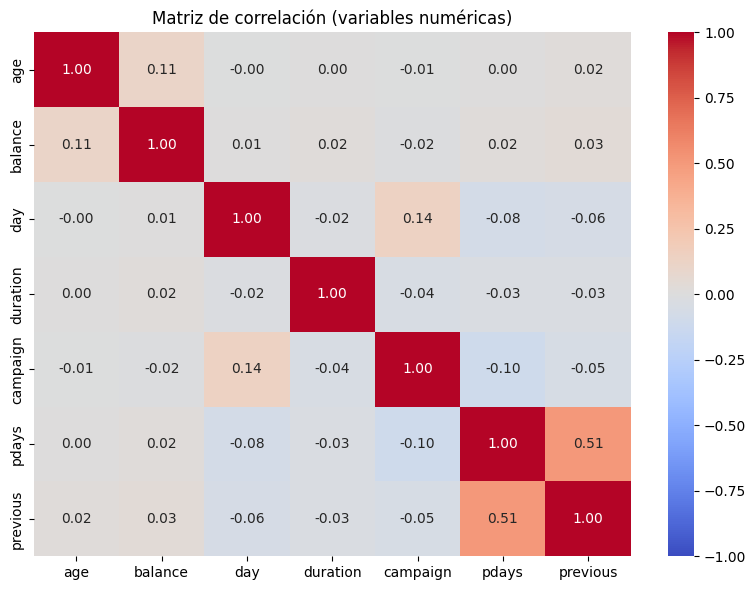

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación (variables numéricas)")
plt.tight_layout()
plt.show()

no hay evidencia de variables numéricas “duplicadas” que obliguen a eliminar alguna por redundancia lineal.

----
### Análisis de `pdays`

`pdays` incluye un valor especial (`-1`) que indica que el cliente **no fue contactado previamente**. Antes de decidir su tratamiento, cuantifico cuántos casos aparecen con `-1` y observo la distribución general.

In [137]:
X["pdays"].value_counts().head(10)

pdays
-1      8203
 92      105
 182      88
 91       82
 181      79
 183      73
 184      51
 94       42
 93       40
 95       37
Name: count, dtype: int64

In [138]:
pct_no_prev_contact = (X["pdays"] == -1).mean() * 100
pct_no_prev_contact

np.float64(74.57272727272726)

Se observa que `pdays=-1` aparece en aproximadamente **el 74.6%** de los registros, lo que indica que en la mayoría de casos el cliente **no fue contactado previamente**. Por tanto, `-1` no debe tratarse como un valor numérico estándar, ya que codifica una condición (“sin contacto previo”) distinta al significado de “días transcurridos”.

Para separar el concepto “¿hubo contacto previo?” del valor numérico “¿cuántos días han pasado?”, creo una variable binaria que indique si el cliente fue contactado previamente.

In [139]:
X["npdays"] = (X["pdays"] != -1).astype(int)
X["pdays"] = X["pdays"].replace(-1, np.nan)

Compruebo que tras la transformación `pdays` contiene valores perdidos exactamente en los casos sin contacto previo, y reviso el reparto de la variable `npdays`.

In [140]:
X["npdays"].value_counts(normalize=True) * 100

npdays
0    74.572727
1    25.427273
Name: proportion, dtype: float64

In [141]:
X["pdays"].isna().mean() * 100

np.float64(74.57272727272726)

---
### Variables numéricas: estadísticos descriptivos

Con `pdays` ya corregida, reviso estadísticas básicas para detectar rangos anómalos y posibles valores extremos.

In [142]:
X[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,11000.0,41.252727,11.940474,18.0,32.00,39.0,49.0,95.0
balance,11000.0,1529.139273,3217.396248,-6847.0,122.75,549.5,1711.0,81204.0
day,11000.0,15.660818,8.417970,1.0,8.00,15.0,22.0,31.0
duration,11000.0,372.524909,347.515713,2.0,138.00,255.0,498.0,3881.0
campaign,11000.0,2.508000,2.722210,1.0,1.00,2.0,3.0,63.0
pdays,2797.0,204.718627,122.397953,1.0,98.00,182.0,286.0,854.0
previous,11000.0,0.828000,2.282936,0.0,0.00,0.0,1.0,58.0


En las variables numéricas destacan `balance` y `duration` por presentar valores extremos (colas largas), lo que sugiere que algunos modelos sensibles a escala podrían beneficiarse de escalado robusto

---
### Variables categóricas: cardinalidad y valores frecuentes

Reviso cuántas categorías tiene cada variable categórica y, como ejemplo, inspecciono las más relevantes para detectar valores dominantes (por ejemplo "unknown") o categorías poco frecuentes.

In [143]:
X[cat_cols].nunique(dropna=False).sort_values(ascending=False)

job          12
month        12
marital       4
poutcome      4
education     4
contact       3
default       2
housing       2
loan          2
dtype: int64

En las variables numéricas destacan `balance` y `duration` por presentar valores extremos (colas largas), lo que sugiere que algunos modelos sensibles a escala podrían beneficiarse de escalado robusto

### Relación con la variable objetivo (comprobación rápida)

Como cierre del EDA, realizo unas comprobaciones simples comparando algunas variables con el target. El objetivo no es “seleccionar features” de forma definitiva, sino detectar señales evidentes y asegurar que las transformaciones propuestas (como `npdays`) tienen sentido antes del modelado.

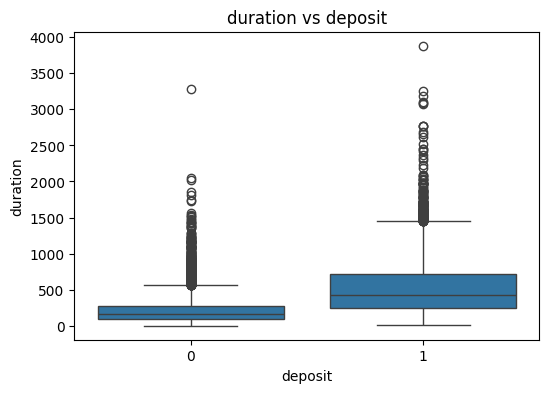

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

tmp = X.copy()
tmp["deposit"] = y

plt.figure(figsize=(6,4))
sns.boxplot(data=tmp, x="deposit", y="duration")
plt.title("duration vs deposit")
plt.show()

In [145]:
pd.crosstab(X["poutcome"], y, normalize="index") * 100

deposit,0,1
poutcome,,
failure,49.503311,50.496689
other,42.803030,57.196970
success,8.593012,91.406988
unknown,59.293114,40.706886


In [146]:
pd.crosstab(X["npdays"], y, normalize="index") * 100

deposit,0,1
npdays,,
0,59.307570,40.692430
1,32.713622,67.286378


En estas comprobaciones rápidas se observa que algunas variables están claramente relacionadas con la variable objetivo. En el boxplot de `duration` se aprecia que los clientes que suscriben (`deposit=1`) tienden a tener duraciones de contacto mayores (mediana y cuartiles superiores), aunque con presencia de valores extremos. En el caso de `poutcome`, la diferencia es muy marcada: cuando el resultado previo fue `success` la probabilidad de suscripción es muy alta (~91%), mientras que categorías como `unknown` presentan tasas sensiblemente menores. Por último, el indicador `npdays` confirma la relevancia del contacto previo: los clientes contactados anteriormente (`npdays=1`) muestran una tasa de suscripción mayor (~67%) frente a los no contactados (`npdays=0`, ~41%), lo que respalda la transformación aplicada a `pdays`.

---
## Partición holdout (evaluación final)

A continuación separo el dataset en un conjunto de entrenamiento y otro de test mediante un esquema holdout (2/3–1/3) y estratificación por la variable objetivo. El objetivo es reservar un conjunto de test que se utilizará únicamente al final, para estimar el rendimiento del modelo en datos no vistos.

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=1/3,
    random_state=100475849,
    stratify=y
)

X_train.shape, X_test.shape

((7333, 17), (3667, 17))